# ADA Project : Creative Extension
## Chilling Effects : Online Surveillance and Wikipedia Use

In this notebook, we extend the analysis done in the paper by using an extended time range, and try to answer the following questions:

1. Is there a persistent, long-term chilling effect related to Snowden’s revelation?
2. Can we highlight new chilling effects due to other scandals?
3. What may be the other factors governing the traffic and how are they affecting the article views?

In [118]:
#internal imports
import scraping

#external imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [119]:
DATA_DIRECTORY = 'data/'
ARTICLES_TITLES = 'articles.txt'
TERRORISM_DATA = 'terrorism.csv'

### Web scraping

The first step is to scrape the website [wikipediaviews](https://wikipediaviews.org) in order to get monthly pageviews of the terrorism-related articles for the time range 2008-2018. Note that the data provided by this site is based on both `stats.grok.se` (for the period before June 2015) and the Wikimedia REST API (for the period after).

We will only consider the English Wikipedia and we ignore pageviews from mobile devices.

In [120]:
# We can scrape the data and save it in a CSV file using this function
#scrape_wikipedia_pageviews(2008, 1, 2018, 12, DATA_DIRECTORY, ARTICLES_TITLES, TERRORISM_DATA)

### Data processing

In [121]:
terrorism_raw = pd.read_csv(DATA_DIRECTORY + TERRORISM_DATA, usecols=[1, 2, 3])
print(terrorism_raw.shape[0], 'lines')
terrorism_raw.head()

6336 lines


,article,date,views
0,abu_sayyaf,2008-01,NaN
1,abu_sayyaf,2008-02,9533.0
2,abu_sayyaf,2008-03,11594.0
3,abu_sayyaf,2008-04,10507.0
4,abu_sayyaf,2008-05,10789.0


In [122]:
#We handle the NaN values 
terrorism = terrorism_raw[~terrorism_raw.views.isna() & terrorism_raw.views != 0]
print(terrorism.shape[0], 'lines')
terrorism.head()

4105 lines


,article,date,views
1,abu_sayyaf,2008-02,9533.0
2,abu_sayyaf,2008-03,11594.0
3,abu_sayyaf,2008-04,10507.0
4,abu_sayyaf,2008-05,10789.0
5,abu_sayyaf,2008-06,15748.0


## Question 1 : Is there a persistant chilling effect ? 

In [123]:
#Now we sum the article viwes of the same month
terror_month = terrorism.groupby(["date"]).sum().reset_index()
#convert date to datetime
terror_month['date']= pd.to_datetime(terror_month['date'])
terror_month["num"] = np.arange(1, len(terror_month)+1)

In [108]:
#create subsets, pre & post June 2013
data_pre = terror_month[terror_month.date <= "2013-06"]
data_post = terror_month[terror_month.date >= "2013-06"]

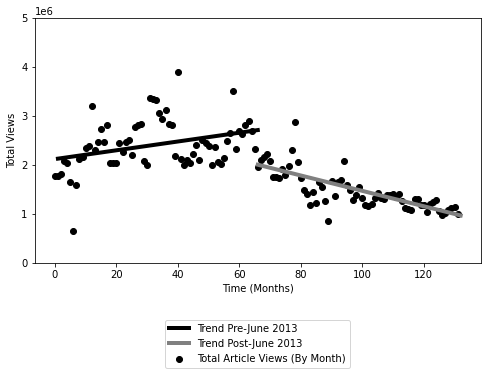

In [124]:
#graphic style
color1 = 'black'
color2 = 'grey'
fig, ax1 = plt.subplots(figsize=(8,4.5))
ax1.set_xlabel("Time (Months)")
ax1.set_ylabel("Total Views")
plt.ylim(0, 5000000)

#scatter the views as a function of the month number
ax1.scatter(terror_month.index, terror_month.views, color=color1, label="Total Article Views (By Month)")

#perform linear regression
#we fit a regressor for each of the post and pre June-2013 subsets

#trend pre-june
trend_pre = LinearRegression()
x_pre = data_pre[["num"]]
y_pre = data_pre[["views"]]
trend_pre.fit(x_pre, y_pre)
Y_pre = trend_pre.predict(x_pre)
p2 = plt.plot(x_pre, Y_pre, label="Trend Pre-June 2013", color=color1, linewidth=4)

#trend post-june
trend_post = LinearRegression()
x_post = data_post[["num"]]
y_post = data_post[["views"]]
trend_post.fit(x_post, y_post)
Y_post = trend_post.predict(x_post)
p3 = plt.plot(x_post, Y_post, label="Trend Post-June 2013", color=color2, linewidth=4)

#Legend adjustments
plt.legend(loc = "lower center", bbox_to_anchor=(0.5, -0.45))
#plt.title("Figure 3. Pre and Post June 2013 Article View Trends (Outliers Excluded). The sudden drop in views and trend shift—from increasing monthly views over time to decreasing after June 2013—is consistent with a significant and long-term chilling effect.",y=-0.55)
plt.show()

## Question 2 : other scandals ?

Potential other scandals we can highlight :

[2013 : Chelsea Manning sentenced to 35 years in prison](https://en.wikipedia.org/wiki/United_States_v._Manning)

[2017 : Vault 7](https://en.wikipedia.org/wiki/Vault_7)

[2018 : Cambridge analytica scandal](https://en.wikipedia.org/wiki/Facebook%E2%80%93Cambridge_Analytica_data_scandal)

[2019 : “the great hack” documentary on Netflix](https://en.wikipedia.org/wiki/The_Great_Hack#Reception)

[2019 : Julian assange arrest](https://en.wikipedia.org/wiki/Julian_Assange)